# Convolutional Neural Network (CNN)

### Import packages

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.python.keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri May  6 02:31:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    59W / 149W |    145MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Reshape, Conv2D, MaxPool2D, ZeroPadding2D, Dense, Dropout, Activation, Flatten, GaussianNoise, MaxPooling2D, AlphaDropout, Input

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pickle

from tensorflow.keras.regularizers import *

import sys, os

### Download and prepare/extract the RADIOML dataset

In [5]:
##From DEEPSIG v2classification, extracting data from pickle file.
with open('/content/drive/MyDrive/Yr3/FYP/RML2016.10a_dict.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    p = u.load()

### Extracting 20 SNR elements and 11 Modulations

In [6]:
snrs, mods = map(lambda j: sorted(list(set(map(lambda x: x[j], p.keys())))), [1,0])


X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(p[(mod,snr)])
        for i in range(p[(mod,snr)].shape[0]):
            lbl.append((mod,snr))

X = np.vstack(X)

In [7]:
X.shape

(220000, 2, 128)

In [8]:
np.random.seed(190)
data_examples = int(X.shape[0])

def partition_data(val):
    data_train = int(data_examples * val)
    data_train_index = np.random.choice(range(0, data_examples), size = data_train, replace = False)
    data_test_index = list(set(range(0, data_examples)) - set(data_train_index))

    X_train_set = X[data_train_index]
    X_test_set = X[data_test_index]
    X_train_test = [X_train_set, X_test_set]
    return X_train_test

In [9]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(190)
n_examples = int(X.shape[0])
n_train = int(n_examples * 0.8)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1

print(lbl[0][0])
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

8PSK


In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

dr = 0.5

(176000, 2, 128) [2, 128]


In [11]:
in_shp

[2, 128]

In [12]:
%cd /content/drive/MyDrive/Yr3/FYP/Lastest_FYP/CNN

/content/drive/MyDrive/Yr3/FYP/Lastest_FYP/CNN


In [ ]:
tf.keras.backend.clear_session()

In [13]:
from tensorflow.python import keras
print(keras.__version__)

2.6.0


# CNN First Model

> ### This Model contains 2 conv layers, 2 zeropadding and contains droupout layers

In [140]:
def CNN1_Model_Design(activation, in_shape, dr, classes):

  model = models.Sequential()
  model.add(Reshape([1] + in_shape, input_shape = in_shape))
  model.add(ZeroPadding2D((0, 2))) ## left_side is symmetric height pad, and right_side is symmetric width pad, so 2 on width
  model.add(Conv2D(256, (1, 3), activation = activation, padding = "same", name = "conv1", kernel_initializer = 'glorot_uniform'))
  model.add(Dropout(dr))
  model.add(Conv2D(256, (2, 3), activation = activation, padding = "same", name = "conv2", kernel_initializer = 'glorot_uniform'))
  # If you wanted to include batch normalisation
  #model.add(ZeroPadding2D((0, 2)))
  model.add(Dropout(dr))
  model.add(ZeroPadding2D((0, 2)))
  model.add(Conv2D(80, (1, 3), activation = activation, padding = "same", name = "conv3", kernel_initializer = 'glorot_uniform'))

  model.add(Dropout(dr))
  #model.add(ZeroPadding2D((0, 2)))
  model.add(Conv2D(80, (1, 3), activation = activation, padding = "same", name = "conv4", kernel_initializer = 'glorot_uniform'))
  #model.add(Conv2D(256, (1, 3), activation = activation, padding = "same", name = "conv1", kernel_initializer = 'glorot_uniform'))
  #If you wanted to include batch normalisation
  model.add(Dropout(dr))

  model.add(Flatten())
  model.add(Dense(128, activation = 'relu', kernel_initializer = 'he_normal', name = 'First_Dense_Layer'))
  model.add(Dropout(dr))
  model.add(Dense(len(classes), kernel_initializer = 'he_normal', name = 'Second_Dense_Layer'))
  model.add(Activation('softmax'))
  model.add(Reshape([len(classes)]))
  

  return model

In [141]:
sig_model = CNN1_Model_Design(activation = 'relu', in_shape = in_shp, dr = 0.4, classes = classes)
opt = tf.keras.optimizers.Adam(learning_rate = 0.005)
sig_model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['acc'])
sig_model.build()
sig_model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_44 (Reshape)        (None, 1, 2, 128)         0         
                                                                 
 zero_padding2d_39 (ZeroPadd  (None, 1, 6, 128)        0         
 ing2D)                                                          
                                                                 
 conv1 (Conv2D)              (None, 1, 6, 256)         98560     
                                                                 
 dropout_66 (Dropout)        (None, 1, 6, 256)         0         
                                                                 
 conv2 (Conv2D)              (None, 1, 6, 256)         393472    
                                                                 
 dropout_67 (Dropout)        (None, 1, 6, 256)         0         
                                                     

In [134]:
epochs_val = 100
batch_size = 1024

In [ ]:
filepath = 'CNNNBPBSB7_24506556985874676874782.h5'
sig_model.compile (loss = 'categorical_crossentropy', optimizer = opt, metrics = ['acc'])
history = sig_model.fit(X_train,
                        Y_train,
                        batch_size = batch_size,
                        epochs = epochs_val,
                        verbose = 2,
                        validation_data = (X_test, Y_test),
                        callbacks = [
                          keras.callbacks.ModelCheckpoint(filepath,
                                                          monitor = 'val_acc',
                                                          verbose = 0,
                                                          save_best_only = True,
                                                          mode = 'auto'),           
                        ])
sig_model.load_weights(filepath)

score = sig_model.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print(score)

Epoch 1/100
172/172 - 9s - loss: 2.0741 - acc: 0.2169 - val_loss: 1.7297 - val_acc: 0.3421 - 9s/epoch - 53ms/step
Epoch 2/100
172/172 - 6s - loss: 1.7531 - acc: 0.3312 - val_loss: 1.6461 - val_acc: 0.3687 - 6s/epoch - 37ms/step
Epoch 3/100
172/172 - 6s - loss: 1.7009 - acc: 0.3489 - val_loss: 1.6248 - val_acc: 0.3811 - 6s/epoch - 38ms/step
Epoch 4/100
172/172 - 6s - loss: 1.6697 - acc: 0.3586 - val_loss: 1.5955 - val_acc: 0.3823 - 6s/epoch - 36ms/step
Epoch 5/100
172/172 - 6s - loss: 1.6380 - acc: 0.3674 - val_loss: 1.5418 - val_acc: 0.3980 - 6s/epoch - 38ms/step
Epoch 6/100
172/172 - 7s - loss: 1.6056 - acc: 0.3755 - val_loss: 1.5174 - val_acc: 0.4101 - 7s/epoch - 39ms/step
Epoch 7/100
172/172 - 7s - loss: 1.5837 - acc: 0.3803 - val_loss: 1.4974 - val_acc: 0.4123 - 7s/epoch - 39ms/step
Epoch 8/100
172/172 - 6s - loss: 1.5669 - acc: 0.3856 - val_loss: 1.4943 - val_acc: 0.4043 - 6s/epoch - 36ms/step
Epoch 9/100
172/172 - 7s - loss: 1.5569 - acc: 0.3896 - val_loss: 1.4858 - val_acc: 0.42

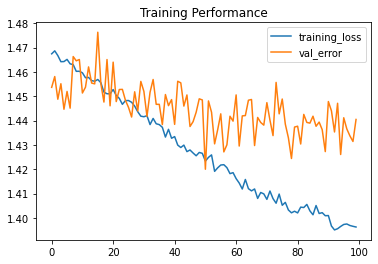

{'loss': [1.467413067817688, 1.468636155128479, 1.4667116403579712, 1.4641797542572021, 1.4642375707626343, 1.4651291370391846, 1.4633057117462158, 1.462982416152954, 1.460223913192749, 1.460250973701477, 1.4596154689788818, 1.457594633102417, 1.457714319229126, 1.4564039707183838, 1.4561491012573242, 1.4568730592727661, 1.455550193786621, 1.45167076587677, 1.4510130882263184, 1.4509873390197754, 1.4527366161346436, 1.450310230255127, 1.4491171836853027, 1.4466679096221924, 1.4482003450393677, 1.448230266571045, 1.4475135803222656, 1.4459354877471924, 1.4436267614364624, 1.4418044090270996, 1.441570520401001, 1.442009449005127, 1.4383525848388672, 1.4408788681030273, 1.4386910200119019, 1.438336968421936, 1.437233328819275, 1.4332191944122314, 1.4363980293273926, 1.4327328205108643, 1.433409571647644, 1.4299311637878418, 1.4289339780807495, 1.4299157857894897, 1.4272434711456299, 1.4279110431671143, 1.4266713857650757, 1.4255400896072388, 1.4268945455551147, 1.426546335220337, 1.423354

In [136]:
plt.figure()
plt.title("Training Performance")
plt.plot(history.epoch, history.history['loss'], label = 'training_loss')
plt.plot(history.epoch, history.history['val_loss'], label = 'val_error')
plt.legend()
plt.show()
print(history.history)
##plt.savefig('Loss_C.png')

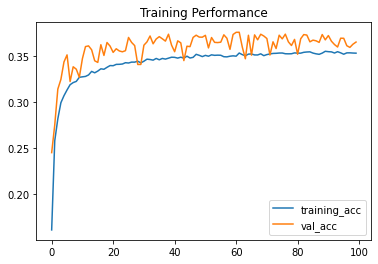

{'loss': [2.2186226844787598, 1.973921537399292, 1.9012361764907837, 1.8511425256729126, 1.8201764822006226, 1.7930797338485718, 1.7808189392089844, 1.7728403806686401, 1.7650688886642456, 1.7568392753601074, 1.753562331199646, 1.7494381666183472, 1.7452194690704346, 1.7391083240509033, 1.739414095878601, 1.736924171447754, 1.7311453819274902, 1.7306602001190186, 1.7282695770263672, 1.726412057876587, 1.7245186567306519, 1.7239129543304443, 1.7193087339401245, 1.7203559875488281, 1.719865083694458, 1.7184027433395386, 1.7161356210708618, 1.717256784439087, 1.7143629789352417, 1.7161870002746582, 1.7105900049209595, 1.7086920738220215, 1.7107880115509033, 1.709547996520996, 1.7106664180755615, 1.70853590965271, 1.7080142498016357, 1.7085962295532227, 1.7035508155822754, 1.7079286575317383, 1.7029545307159424, 1.7074323892593384, 1.7065608501434326, 1.704944372177124, 1.7043776512145996, 1.7021443843841553, 1.7023199796676636, 1.6978535652160645, 1.701790690422058, 1.7029598951339722, 1.

In [103]:
plt.figure()
plt.title("Training Performance")
plt.plot(history.epoch, history.history['acc'], label = 'training_acc')
plt.plot(history.epoch, history.history['val_acc'], label = 'val_acc')
plt.legend()
plt.show()
print(history.history)

In [137]:
def plot_confusion_matrix(cm, title = 'confusion matrix', cmap = plt.cm.Blues, labels = []):
  my_dpi = 96
  plt.figure(figsize = (400/my_dpi, 350/my_dpi), dpi = my_dpi)
  plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation = 45)
  plt.yticks(tick_marks, labels)
  plt.tight_layout()
  plt.xlabel('True Labels')
  plt.ylabel('Predicated Labels')


test_y_hat = sig_model.predict(X_test, batch_size = batch_size)

conf = np.zeros([len(classes), len(classes)])

conf_norm = np.zeros([len(classes), len(classes)])

In [105]:
X_test.shape

(44000, 2, 128)

[[5.41592920e-01 9.60809102e-03 2.90518331e-01 9.10240202e-03
  1.08975980e-01 6.06826802e-03 1.26422250e-03 0.00000000e+00
  5.81542351e-03 2.09860936e-02 6.06826802e-03]
 [1.32029340e-02 7.11735941e-01 2.06601467e-01 1.95599022e-03
  7.57946210e-03 9.29095355e-03 2.44498778e-04 0.00000000e+00
  4.88997555e-04 1.46699267e-03 4.74327628e-02]
 [5.24614620e-02 2.41173545e-02 8.73694679e-01 7.70760816e-03
  1.74042765e-02 7.70760816e-03 1.24316261e-03 0.00000000e+00
  0.00000000e+00 6.46444555e-03 9.19940328e-03]
 [5.20159283e-02 8.71080139e-03 2.82727725e-01 5.94574415e-01
  2.21503235e-02 6.47088104e-03 1.94126431e-02 0.00000000e+00
  1.24440020e-03 8.95968143e-03 3.73320060e-03]
 [6.57114625e-02 8.89328063e-03 2.78162055e-01 7.16403162e-03
  6.07460474e-01 1.60573123e-02 9.88142292e-04 0.00000000e+00
  2.47035573e-04 9.63438735e-03 5.68181818e-03]
 [2.10472279e-02 1.51437372e-02 2.58470226e-01 3.85010267e-03
  4.33778234e-02 6.23973306e-01 5.13347023e-04 0.00000000e+00
  5.13347023e-04

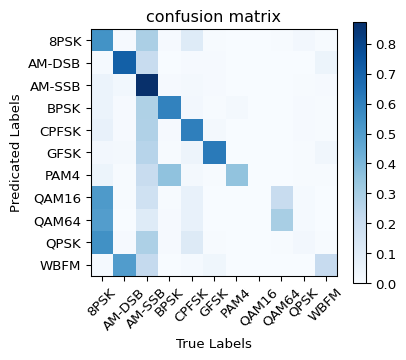

In [138]:
for i in range(0, X_test.shape[0]):
  j = list(Y_test[i, :]).index(1)
  k = int(np.argmax(test_y_hat[i, :]))
  conf[j, k] = conf[j, k] + 1


for i in range(0, len(classes)):
  conf_norm[i, :] = conf[i, :] / np.sum(conf[i, :])

print(conf_norm)
print(classes)

plot_confusion_matrix(conf_norm, labels = classes)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


{-20: 0.09326660600545951, -18: 0.10222626079054975, -16: 0.09287646528403967, -14: 0.10214094558429973, -12: 0.12453183520599251, -10: 0.17853881278538813, -8: 0.2665466006303467, -6: 0.38881371222372574, -4: 0.47539503386004517, -2: 0.5805415328132171, 0: 0.6349792339640056, 2: 0.6303660189787619, 4: 0.6381727725011307, 6: 0.6559571619812584, 8: 0.6370638876302673, 10: 0.654521510096576, 12: 0.6424632352941176, 14: 0.6402609506057781, 16: 0.6400367309458218, 18: 0.6454293628808865}


<Figure size 432x288 with 0 Axes>

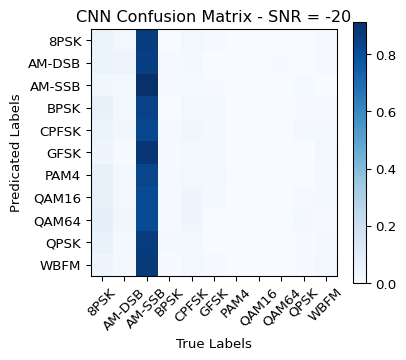

<Figure size 432x288 with 0 Axes>

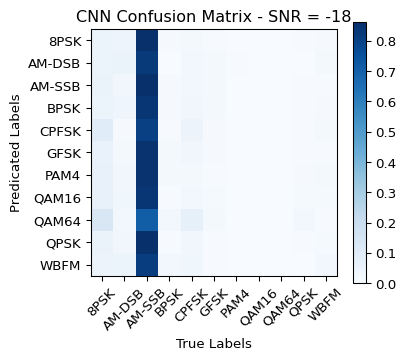

<Figure size 432x288 with 0 Axes>

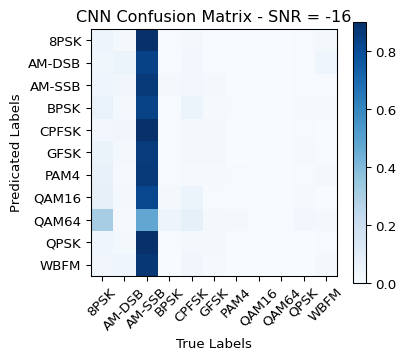

<Figure size 432x288 with 0 Axes>

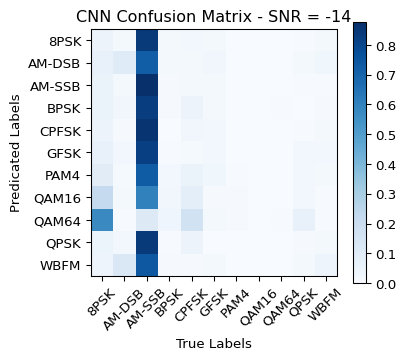

<Figure size 432x288 with 0 Axes>

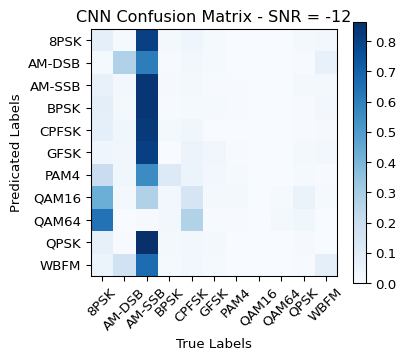

<Figure size 432x288 with 0 Axes>

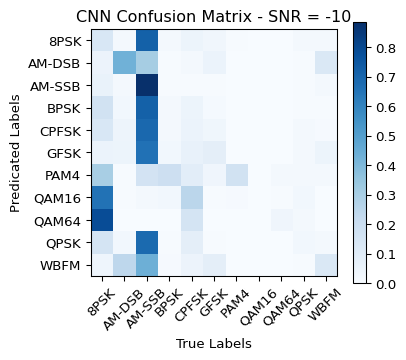

<Figure size 432x288 with 0 Axes>

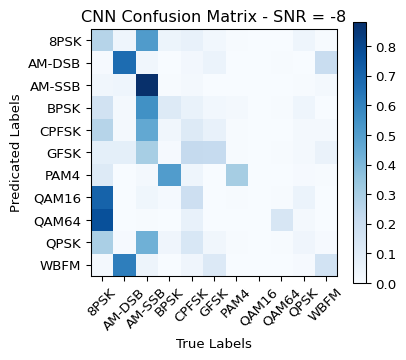

<Figure size 432x288 with 0 Axes>

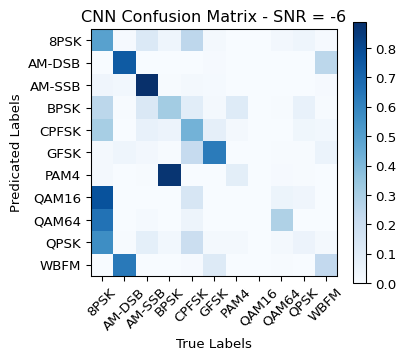

<Figure size 432x288 with 0 Axes>

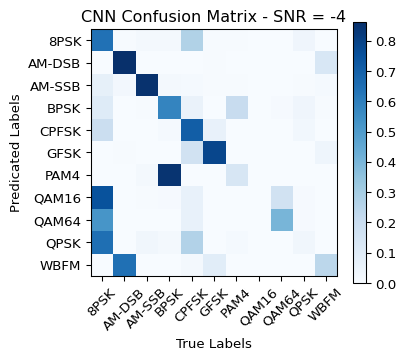

<Figure size 432x288 with 0 Axes>

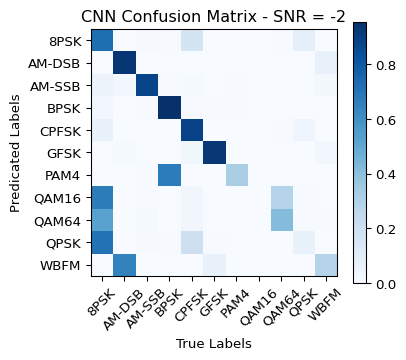

<Figure size 432x288 with 0 Axes>

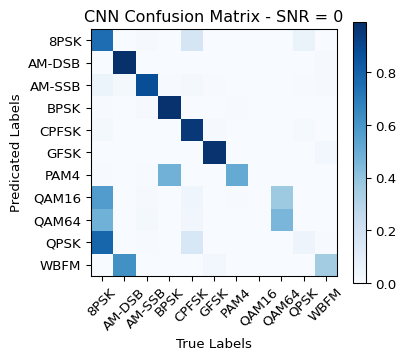

<Figure size 432x288 with 0 Axes>

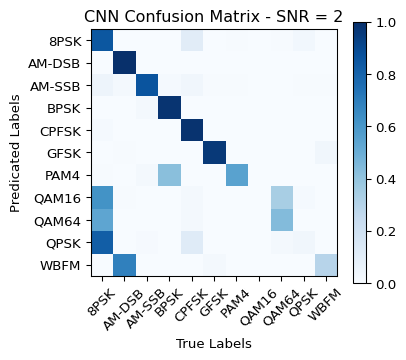

<Figure size 432x288 with 0 Axes>

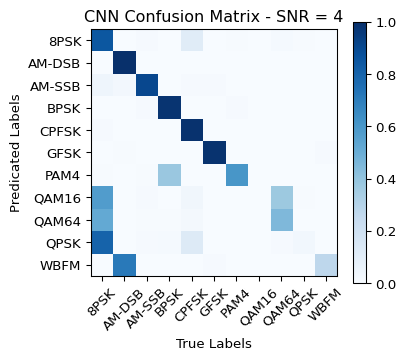

<Figure size 432x288 with 0 Axes>

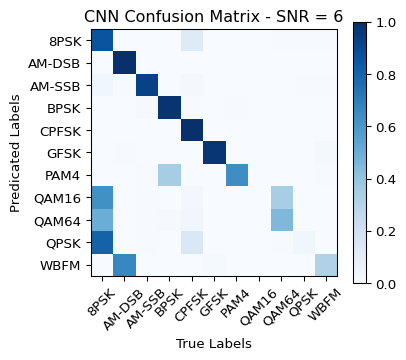

<Figure size 432x288 with 0 Axes>

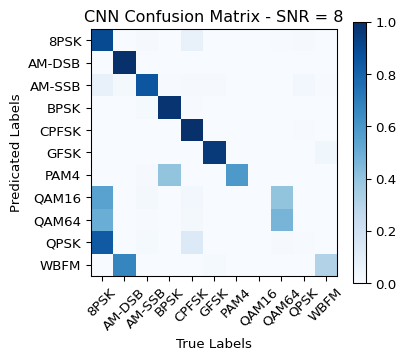

<Figure size 432x288 with 0 Axes>

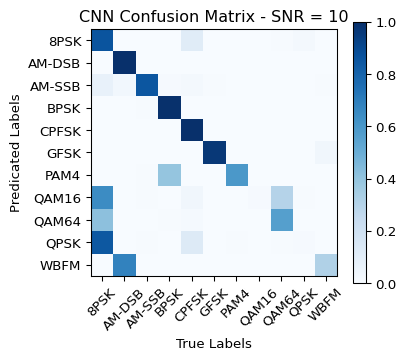

<Figure size 432x288 with 0 Axes>

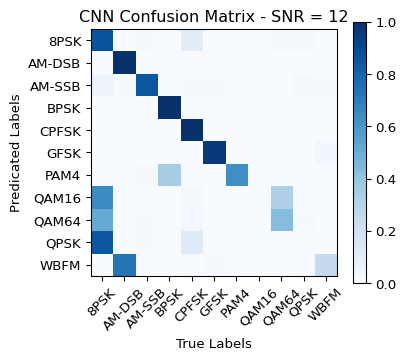

<Figure size 432x288 with 0 Axes>

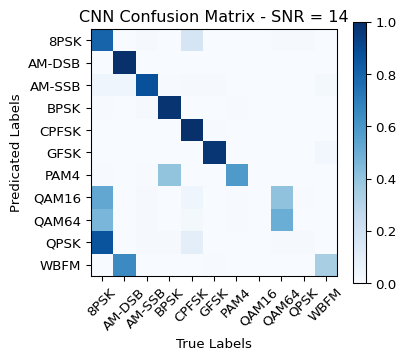

<Figure size 432x288 with 0 Axes>

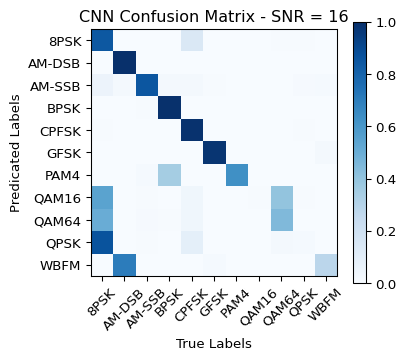

<Figure size 432x288 with 0 Axes>

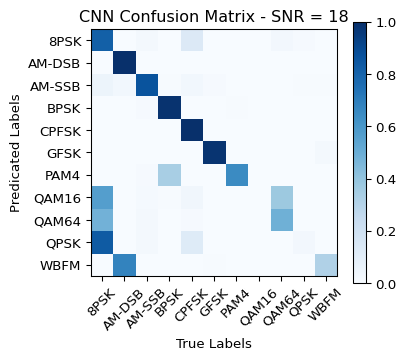

In [139]:
acc = {}

for snr in snrs:

  test_SNRS = list(map(lambda x: lbl[x][1], test_idx))
  test_X_i = X_test[np.where(np.array(test_SNRS) == snr)]
  test_Y_i = Y_test[np.where(np.array(test_SNRS) == snr)]

  test_Y_i_hat = sig_model.predict(test_X_i)

  conf = np.zeros([len(classes), len(classes)])
  conf_norm = np.zeros([len(classes), len(classes)])

  for i in range(0, test_X_i.shape[0]):
    j = list(test_Y_i[i, :]).index(1)
    k = int(np.argmax(test_Y_i_hat[i, :]))
    conf[j, k] = conf[j, k] + 1


  for i in range(0, len(classes)):
    conf_norm[i, :] = conf[i, :] / np.sum(conf[i, :])

  plt.figure()
  plot_confusion_matrix(conf_norm, labels = classes, title = "CNN Confusion Matrix - SNR = %d" % (snr))

  cor = np.sum(np.diag(conf))
  ncor = np.sum(conf) - cor
  acc[snr] = 1.0 * cor/ (cor + ncor)


print(acc)

In [ ]:
def residual_stack(X,Filters,Seq,max_pool):
    #1*1 Conv Linear
    X = Conv2D(Filters, (1, 1), padding='same', name=Seq+"_conv1", kernel_initializer ='glorot_uniform',data_format="channels_first")(X)
    #Residual Unit 1
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same',activation="relu",name=Seq+"_conv2", kernel_initializer ='glorot_uniform',data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv3", kernel_initializer = 'glorot_uniform',data_format="channels_first")(X)
    X = layers.add([X,X_shortcut])
    X = Activation("relu")(X)
    #Residual Unit 2
    X_shortcut = X
    X = Conv2D(Filters, (3, 2), padding='same',activation="relu",name=Seq+"_conv4", kernel_initializer ='glorot_uniform',data_format="channels_first")(X)
    X = Conv2D(Filters, (3, 2), padding='same', name=Seq+"_conv5", kernel_initializer ='glorot_uniform',data_format="channels_first")(X)
    X = layers.add([X,X_shortcut])
    X = Activation("relu")(X)
    #MaxPooling
    ##if max_pool:
        ##X = MaxPooling2D(pool_size=(2, 1), strides=(2, 1), padding='valid', data_format="channels_first")(X)
    return X

In [ ]:
##in_shp = X_train.shape[1:]   #每个样本的维度
#input layer
X_input = Input(in_shp)
X = Reshape([1,2,128], input_shape=in_shp)(X_input)
#Residual Srack 1
X = residual_stack(X,32,"ReStk1",False)  #shape:(1,512,32)
X = MaxPooling2D(pool_size=(2, 2), strides=(2, 1), padding='valid', data_format="channels_first")(X)
#Residual Srack 2
X = residual_stack(X,32,"ReStk2",True)  #shape:(1,256,32)
#Residual Srack 3
X = residual_stack(X,32,"ReStk3",True)  #shape:(1,128,32)
#Residual Srack 4
X = residual_stack(X,32,"ReStk4",True)  #shape:(1,64,32)
#Residual Srack 5
X = residual_stack(X,32,"ReStk5",True)  #shape:(1,32,32)
#Residual Srack 6
X = residual_stack(X,32,"ReStk6",True)  #shape:(1,16,32)
#Full Con 1
X = Flatten()(X)
X = Dense(128, activation='selu', kernel_initializer ='he_normal', name="dense1")(X)
X = AlphaDropout(0.3)(X)
#Full Con 2
X = Dense(128, activation='selu', kernel_initializer ='he_normal', name="dense2")(X)
X = AlphaDropout(0.3)(X)
#Full Con 3
X = Dense(len(classes), kernel_initializer ='he_normal', name="dense3")(X)
#SoftMax
X = Activation('softmax')(X)
#Create Model
model = models.Model(inputs=X_input,outputs=X)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2, 128)]     0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 2, 128)    0           ['input_1[0][0]']                
                                                                                                  
 ReStk1_conv1 (Conv2D)          (None, 32, 2, 128)   64          ['reshape[0][0]']                
                                                                                                  
 ReStk1_conv2 (Conv2D)          (None, 32, 2, 128)   6176        ['ReStk1_conv1[0][0]']           
                                                                                              

In [ ]:
print(tf.test.gpu_device_name())
filepath = 'resnet_6.h5'

history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs_val,
    verbose=2,
    validation_data=(X_test, Y_test),
    #validation_split = 0.2,
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=0, save_best_only=True, mode='auto'),
        ##keras.callbacks.EarlyStopping(monitor='val_acc', patience=5, verbose=0, mode='auto')
    ])

model.load_weights(filepath)

score = model.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print(score)

/device:GPU:0
Epoch 1/100
172/172 - 20s - loss: 2.4638 - acc: 0.0908 - val_loss: 2.4122 - val_acc: 0.0927 - 20s/epoch - 117ms/step
Epoch 2/100
172/172 - 15s - loss: 2.4019 - acc: 0.0903 - val_loss: 2.4067 - val_acc: 0.0914 - 15s/epoch - 87ms/step
Epoch 3/100
172/172 - 15s - loss: 2.4013 - acc: 0.0914 - val_loss: 2.4053 - val_acc: 0.0932 - 15s/epoch - 90ms/step
Epoch 4/100
172/172 - 15s - loss: 2.2596 - acc: 0.1501 - val_loss: 2.1015 - val_acc: 0.2245 - 15s/epoch - 90ms/step
Epoch 5/100
172/172 - 15s - loss: 1.9894 - acc: 0.2540 - val_loss: 1.9174 - val_acc: 0.2966 - 15s/epoch - 89ms/step
Epoch 6/100
172/172 - 15s - loss: 1.8090 - acc: 0.3168 - val_loss: 1.7749 - val_acc: 0.3593 - 15s/epoch - 89ms/step
Epoch 7/100
172/172 - 15s - loss: 1.6820 - acc: 0.3624 - val_loss: 1.6715 - val_acc: 0.3942 - 15s/epoch - 89ms/step
Epoch 8/100
172/172 - 15s - loss: 1.6000 - acc: 0.3964 - val_loss: 1.5565 - val_acc: 0.4304 - 15s/epoch - 89ms/step
Epoch 9/100
172/172 - 15s - loss: 1.4917 - acc: 0.4343 - 

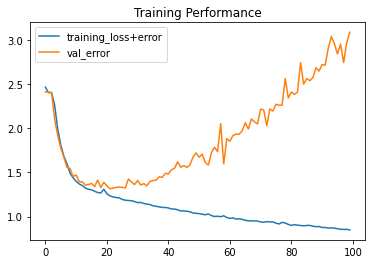

{'loss': [2.463783025741577, 2.4019246101379395, 2.4012815952301025, 2.259567975997925, 1.9893531799316406, 1.8089834451675415, 1.6819559335708618, 1.6000157594680786, 1.4917027950286865, 1.4382818937301636, 1.399170994758606, 1.3690924644470215, 1.3507744073867798, 1.322960376739502, 1.3084287643432617, 1.3037052154541016, 1.286172866821289, 1.2722301483154297, 1.2666858434677124, 1.3096108436584473, 1.2583626508712769, 1.2344810962677002, 1.221476674079895, 1.2157697677612305, 1.2115367650985718, 1.193657398223877, 1.1854667663574219, 1.1823163032531738, 1.1788228750228882, 1.169956088066101, 1.1574090719223022, 1.160866379737854, 1.1480920314788818, 1.1406989097595215, 1.1367177963256836, 1.121700406074524, 1.116267204284668, 1.1099101305007935, 1.1037012338638306, 1.1027649641036987, 1.0975407361984253, 1.0855168104171753, 1.0850872993469238, 1.077283501625061, 1.064724087715149, 1.0638723373413086, 1.0604774951934814, 1.0544122457504272, 1.040769338607788, 1.0372986793518066, 1.03

In [ ]:
plt.figure()
plt.title("Training Performance")
plt.plot(history.epoch, history.history['loss'], label = 'training_loss+error')
plt.plot(history.epoch, history.history['val_loss'], label = 'val_error')
plt.legend()
plt.show()
print(history.history)

In [ ]:
def plot_confusion_matrix(cm, title = 'ResNet confusion matrix', cmap = plt.cm.Blues, labels = []):
  my_dpi = 96
  plt.figure(figsize = (400/my_dpi, 350/my_dpi), dpi = my_dpi)
  plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(labels))
  plt.xticks(tick_marks, labels, rotation = 45)
  plt.yticks(tick_marks, labels)
  plt.tight_layout()
  plt.xlabel('True Labels')
  plt.ylabel('Predicated Labels')


test_y_hat = model.predict(X_test, batch_size = batch_size)

conf = np.zeros([len(classes), len(classes)])

conf_norm = np.zeros([len(classes), len(classes)])

[[4.98027613e-01 2.46548323e-03 3.52071006e-01 1.10946746e-02
  1.97238659e-02 9.86193294e-03 6.16370809e-03 5.15285996e-02
  4.43786982e-03 3.59960552e-02 8.62919132e-03]
 [1.03950104e-03 6.22661123e-01 2.62733888e-01 5.97713098e-03
  1.81912682e-03 9.87525988e-03 1.29937630e-03 5.19750520e-04
  0.00000000e+00 0.00000000e+00 9.40748441e-02]
 [2.78269669e-03 6.32431065e-03 9.44346066e-01 3.03566911e-03
  8.60106248e-03 6.57728308e-03 1.77080698e-03 1.01188970e-03
  0.00000000e+00 0.00000000e+00 2.55502150e-02]
 [1.00564140e-02 1.71694874e-03 3.39955850e-01 5.86215354e-01
  4.90556782e-03 6.37723817e-03 3.11503557e-02 3.92445426e-03
  2.45278391e-04 4.90556782e-03 1.05469708e-02]
 [2.61569416e-02 3.52112676e-03 3.29979879e-01 4.52716298e-03
  5.96076459e-01 1.53420523e-02 3.52112676e-03 7.29376258e-03
  7.54527163e-04 2.76659960e-03 1.00603622e-02]
 [9.11779202e-03 9.11779202e-03 3.23804830e-01 2.71069492e-03
  1.84820108e-02 6.09167077e-01 1.72498768e-03 2.71069492e-03
  2.46426811e-04

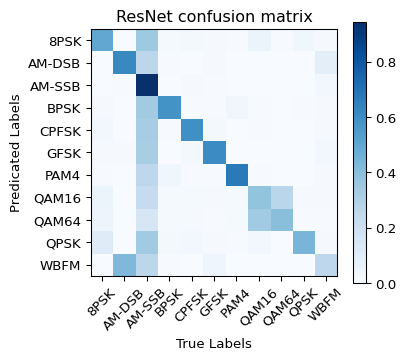

In [ ]:
for i in range(0, X_test.shape[0]):
  j = list(Y_test[i, :]).index(1)
  k = int(np.argmax(test_y_hat[i, :]))
  conf[j, k] = conf[j, k] + 1


for i in range(0, len(classes)):
  conf_norm[i, :] = conf[i, :] / np.sum(conf[i, :])

print(conf_norm)
print(classes)

plot_confusion_matrix(conf_norm, labels = classes)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


{-20: 0.09205776173285199, -18: 0.0935088515660463, -16: 0.09119927040583675, -14: 0.09880514705882353, -12: 0.13088301210219633, -10: 0.17657342657342656, -8: 0.30095238095238097, -6: 0.4373596766951055, -4: 0.5838862559241706, -2: 0.68935041979673, 0: 0.7414024117909781, 2: 0.7886216466234968, 4: 0.8181401740723775, 6: 0.8293903548680619, 8: 0.8355293048614266, 10: 0.8405797101449275, 12: 0.8451788139429606, 14: 0.8397584765443568, 16: 0.8346994535519126, 18: 0.8435828877005348}


<Figure size 432x288 with 0 Axes>

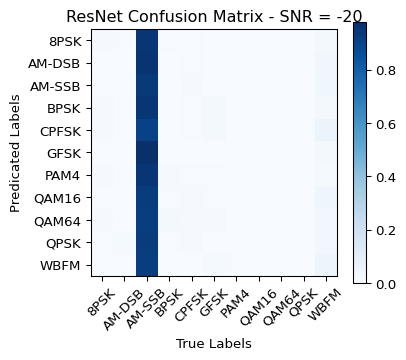

<Figure size 432x288 with 0 Axes>

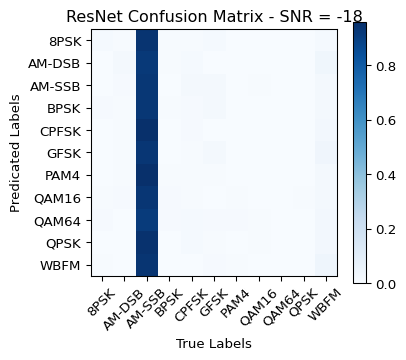

<Figure size 432x288 with 0 Axes>

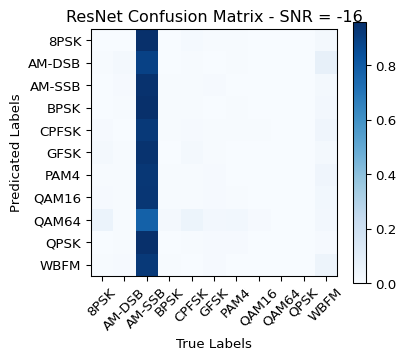

<Figure size 432x288 with 0 Axes>

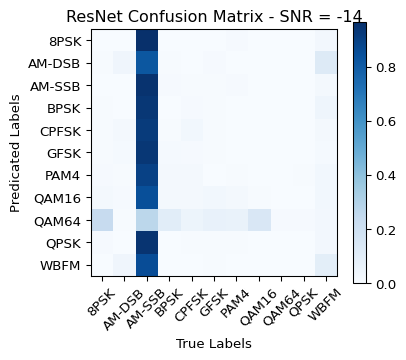

<Figure size 432x288 with 0 Axes>

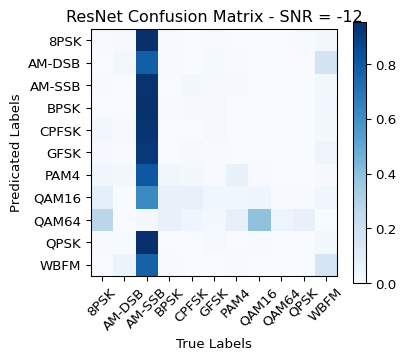

<Figure size 432x288 with 0 Axes>

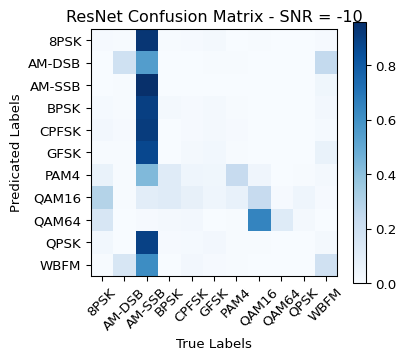

<Figure size 432x288 with 0 Axes>

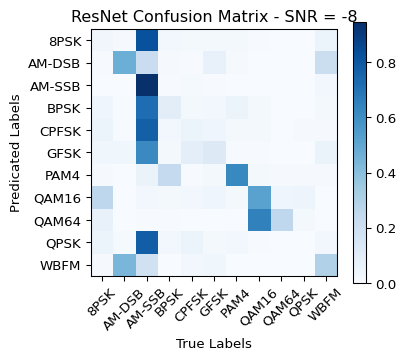

<Figure size 432x288 with 0 Axes>

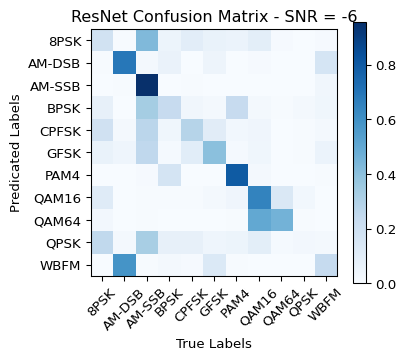

<Figure size 432x288 with 0 Axes>

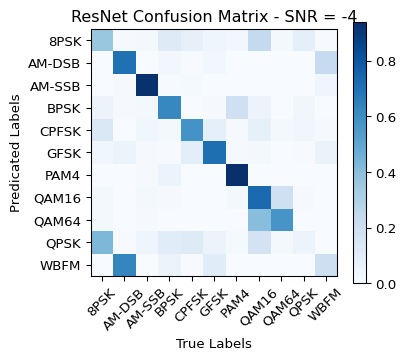

<Figure size 432x288 with 0 Axes>

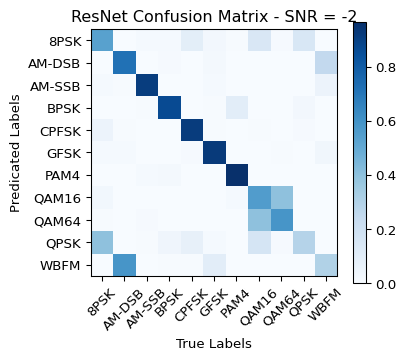

<Figure size 432x288 with 0 Axes>

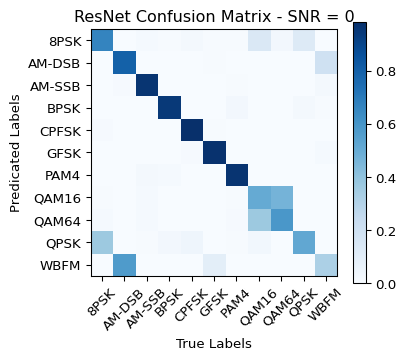

<Figure size 432x288 with 0 Axes>

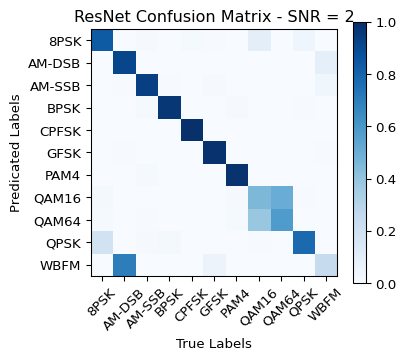

<Figure size 432x288 with 0 Axes>

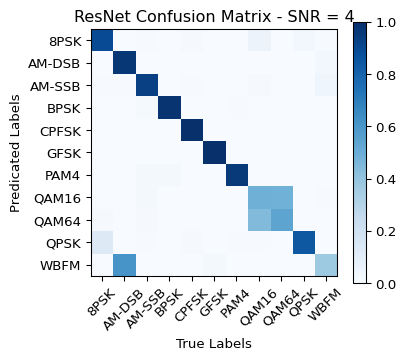

<Figure size 432x288 with 0 Axes>

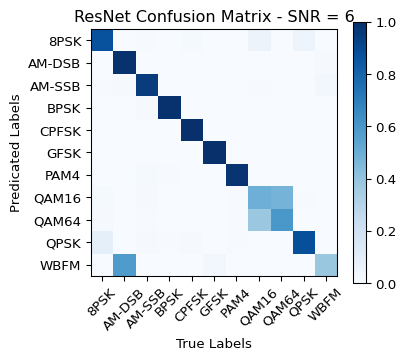

<Figure size 432x288 with 0 Axes>

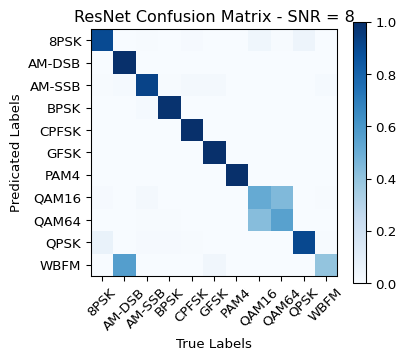

<Figure size 432x288 with 0 Axes>

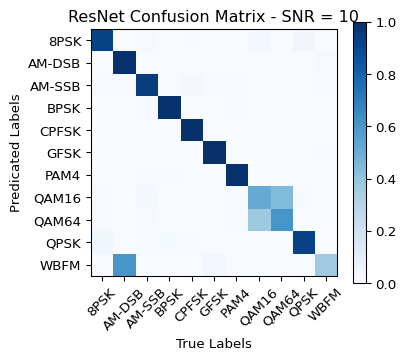

<Figure size 432x288 with 0 Axes>

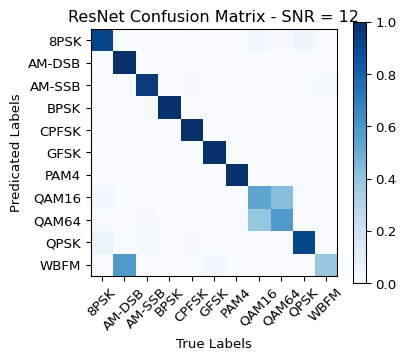

<Figure size 432x288 with 0 Axes>

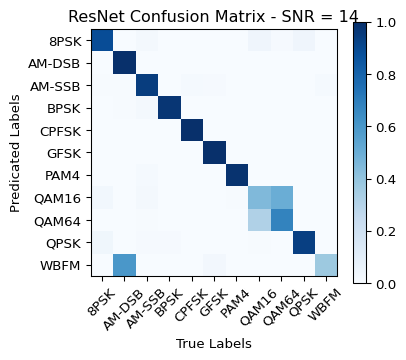

<Figure size 432x288 with 0 Axes>

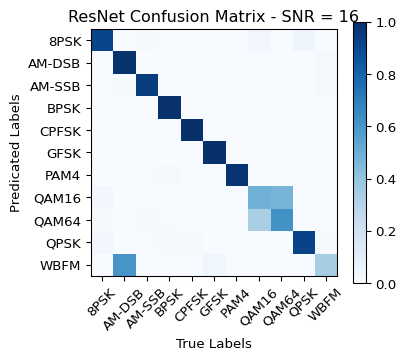

<Figure size 432x288 with 0 Axes>

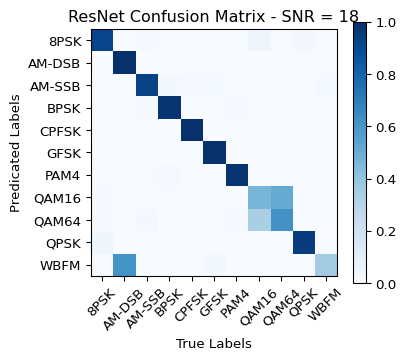

In [ ]:
acc = {}

for snr in snrs:

  test_SNRS = list(map(lambda x: lbl[x][1], test_idx))
  test_X_i = X_test[np.where(np.array(test_SNRS) == snr)]
  test_Y_i = Y_test[np.where(np.array(test_SNRS) == snr)]

  test_Y_i_hat = model.predict(test_X_i)

  conf = np.zeros([len(classes), len(classes)])
  conf_norm = np.zeros([len(classes), len(classes)])

  for i in range(0, test_X_i.shape[0]):
    j = list(test_Y_i[i, :]).index(1)
    k = int(np.argmax(test_Y_i_hat[i, :]))
    conf[j, k] = conf[j, k] + 1


  for i in range(0, len(classes)):
    conf_norm[i, :] = conf[i, :] / np.sum(conf[i, :])

  plt.figure()
  plot_confusion_matrix(conf_norm, labels = classes, title = "ResNet Confusion Matrix - SNR = %d" % (snr))

  cor = np.sum(np.diag(conf))
  ncor = np.sum(conf) - cor
  acc[snr] = 1.0 * cor/ (cor + ncor)


print(acc)

In [ ]:
filepath = 'CNN1_1.h5'
sig_model.compile (loss = 'categorical_crossentropy', optimizer = opt, metrics = ['acc'])
history = sig_model.fit(X_train,
                        Y_train,
                        batch_size = batch_size,
                        epochs = epochs_val,
                        verbose = 2,
                        validation_data = (X_test, Y_test),
                        callbacks = [
                          keras.callbacks.ModelCheckpoint(filepath,
                                                          monitor = 'val_acc',
                                                          verbose = 0,
                                                          save_best_only = True,
                                                          mode = 'auto'),           
                        ])
sig_model.load_weights(filepath)

score = sig_model.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print(score)



> ### This is the second variation of Model 1, the 2 conv layers swapped.



In [51]:
def CNN1_Model_Design_1_2(activation, in_shape, dr, classes):

  model = models.Sequential()
  model.add(Reshape([1] + in_shape, input_shape = in_shape))
  model.add(ZeroPadding2D((0, 2))) ## left_side is symmetric height pad, and right_side is symmetric width pad, so 2 on width
  ##model.add(Conv2D(256, (1, 3), activation = activation, padding = "same", name = "conv1", kernel_initializer = 'glorot_uniform'))
  model.add(Conv2D(80, (2, 3), activation = activation, padding = "same", name = "conv2", kernel_initializer = 'glorot_uniform'))
  # If you wanted to include batch normalisation

  ##model.add(Dropout(dr))
  model.add(ZeroPadding2D((0, 2)))
  model.add(Conv2D(256, (1, 3), activation = activation, padding = "same", name = "conv1", kernel_initializer = 'glorot_uniform'))
  ##model.add(Conv2D(80, (2, 3), activation = activation, padding = "same", name = "conv2", kernel_initializer = 'glorot_uniform'))
  #If you wanted to include batch normalisation

  ##model.add(Dropout(dr))
  model.add(Flatten())
  model.add(Dense(256, activation = 'relu', kernel_initializer = 'he_normal', name = 'First_Dense_Layer'))
  ##model.add(Dropout(dr))
  model.add(Dense(len(classes), kernel_initializer = 'he_normal', name = 'Second_Dense_Layer'))
  model.add(Activation('softmax'))
  model.add(Reshape([len(classes)]))
  

  return model

In [52]:
sig_model_1_2 = CNN1_Model_Design_1_2(activation = 'relu', in_shape = in_shp, dr = dr, classes = classes)
opt = tf.keras.optimizers.Adam(learning_rate = 0.005)
sig_model_1_2.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['acc'])
sig_model_1_2.build()
sig_model_1_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_10 (Reshape)        (None, 1, 2, 128)         0         
                                                                 
 zero_padding2d_10 (ZeroPadd  (None, 1, 6, 128)        0         
 ing2D)                                                          
                                                                 
 conv2 (Conv2D)              (None, 1, 6, 80)          61520     
                                                                 
 zero_padding2d_11 (ZeroPadd  (None, 1, 10, 80)        0         
 ing2D)                                                          
                                                                 
 conv1 (Conv2D)              (None, 1, 10, 256)        61696     
                                                                 
 flatten_5 (Flatten)         (None, 2560)             

In [44]:
filepath = 'CNN1_1_7.h5'
sig_model_1_2.compile (loss = 'categorical_crossentropy', optimizer = opt, metrics = ['acc'])
history = sig_model_1_2.fit(X_train,
                        Y_train,
                        batch_size = batch_size,
                        epochs = epochs_val,
                        verbose = 2,
                        validation_data = (X_test, Y_test),
                        callbacks = [
                          keras.callbacks.ModelCheckpoint(filepath,
                                                          monitor = 'val_acc',
                                                          verbose = 0,
                                                          save_best_only = True,
                                                          mode = 'auto'),           
                        ])
sig_model_1_2.load_weights(filepath)

score = sig_model_1_2.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print(score)

Epoch 1/100
172/172 - 6s - loss: 2.0978 - acc: 0.2131 - val_loss: 1.8730 - val_acc: 0.2994 - 6s/epoch - 34ms/step
Epoch 2/100
172/172 - 3s - loss: 1.8614 - acc: 0.2985 - val_loss: 1.7241 - val_acc: 0.3407 - 3s/epoch - 18ms/step
Epoch 3/100
172/172 - 3s - loss: 1.7748 - acc: 0.3228 - val_loss: 1.6679 - val_acc: 0.3580 - 3s/epoch - 18ms/step
Epoch 4/100
172/172 - 3s - loss: 1.7278 - acc: 0.3365 - val_loss: 1.6529 - val_acc: 0.3735 - 3s/epoch - 18ms/step
Epoch 5/100
172/172 - 3s - loss: 1.6980 - acc: 0.3473 - val_loss: 1.6453 - val_acc: 0.3690 - 3s/epoch - 17ms/step
Epoch 6/100
172/172 - 3s - loss: 1.6812 - acc: 0.3519 - val_loss: 1.6097 - val_acc: 0.3768 - 3s/epoch - 18ms/step
Epoch 7/100
172/172 - 3s - loss: 1.6636 - acc: 0.3573 - val_loss: 1.6065 - val_acc: 0.3858 - 3s/epoch - 18ms/step
Epoch 8/100
172/172 - 3s - loss: 1.6515 - acc: 0.3613 - val_loss: 1.5802 - val_acc: 0.3923 - 3s/epoch - 17ms/step
Epoch 9/100
172/172 - 3s - loss: 1.6387 - acc: 0.3644 - val_loss: 1.5751 - val_acc: 0.39

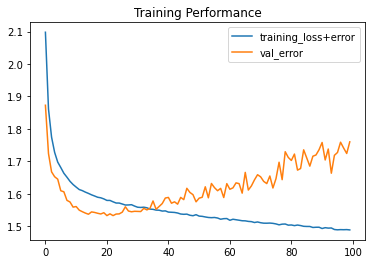

{'loss': [2.0977513790130615, 1.8613570928573608, 1.7748485803604126, 1.727781057357788, 1.6979538202285767, 1.6811681985855103, 1.663599967956543, 1.651487946510315, 1.638702630996704, 1.6288608312606812, 1.6209458112716675, 1.6134183406829834, 1.6100804805755615, 1.605454921722412, 1.6015459299087524, 1.5971417427062988, 1.593532681465149, 1.5896903276443481, 1.5880436897277832, 1.5846035480499268, 1.5799733400344849, 1.5799071788787842, 1.575646996498108, 1.5719115734100342, 1.5718284845352173, 1.5689014196395874, 1.565753698348999, 1.5659759044647217, 1.5667567253112793, 1.562503695487976, 1.558951497077942, 1.5583313703536987, 1.5590630769729614, 1.5573168992996216, 1.5532875061035156, 1.5524792671203613, 1.5501391887664795, 1.549747109413147, 1.5471224784851074, 1.547737717628479, 1.5439958572387695, 1.5434925556182861, 1.5429017543792725, 1.54119074344635, 1.5380691289901733, 1.5371800661087036, 1.5377237796783447, 1.5342661142349243, 1.5328346490859985, 1.5359810590744019, 1.53

In [45]:
plt.figure()
plt.title("Training Performance")
plt.plot(history.epoch, history.history['loss'], label = 'training_loss+error')
plt.plot(history.epoch, history.history['val_loss'], label = 'val_error')
plt.legend()
plt.show()
print(history.history)
##plt.savefig('Loss_C.png')

> ### This is the second variation of Model 1. Does batch normalization after each conv layer



In [46]:
def CNN1_Model_Design_2(batch_normalization, activation, in_shape, dr, classes):

  model = models.Sequential()
  model.add(Reshape([1] + in_shape, input_shape = in_shape))
  model.add(ZeroPadding2D((0, 2))) ## left_side is symmetric height pad, and right_side is symmetric width pad, so 2 on width
  model.add(Conv2D(256, (1, 3), activation = activation, padding = "same", name = "conv1", kernel_initializer = 'glorot_uniform'))
  # If you wanted to include batch normalisation
  if(batch_normalization):
    model.add(tf.keras.layers.BatchNormalization())

  model.add(Dropout(dr))
  model.add(ZeroPadding2D((0, 2)))
  model.add(Conv2D(80, (2, 3), activation = activation, padding = "same", name = "conv2", kernel_initializer = 'glorot_uniform'))
  #If you wanted to include batch normalisation
  if(batch_normalization):
    model.add(tf.keras.layers.BatchNormalization())

  model.add(Dropout(dr))
  model.add(Flatten())
  model.add(Dense(256, activation = 'relu', kernel_initializer = 'he_normal', name = 'First_Dense_Layer'))
  model.add(Dropout(dr))
  model.add(Dense(len(classes), kernel_initializer = 'he_normal', name = 'Second_Dense_Layer'))
  model.add(Activation('softmax'))
  model.add(Reshape([len(classes)]))
  

  return model

In [47]:
sig_model_2 = CNN1_Model_Design_2(batch_normalization = True, activation = 'relu', in_shape = in_shp, dr = dr, classes = classes)
opt_2 = tf.keras.optimizers.Adam(learning_rate = 0.005)
sig_model_2.compile(loss = 'categorical_crossentropy', optimizer = opt_2, metrics = ['acc'])
sig_model_2.build()
sig_model_2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_8 (Reshape)         (None, 1, 2, 128)         0         
                                                                 
 zero_padding2d_8 (ZeroPaddi  (None, 1, 6, 128)        0         
 ng2D)                                                           
                                                                 
 conv1 (Conv2D)              (None, 1, 6, 256)         98560     
                                                                 
 batch_normalization (BatchN  (None, 1, 6, 256)        1024      
 ormalization)                                                   
                                                                 
 dropout_12 (Dropout)        (None, 1, 6, 256)         0         
                                                                 
 zero_padding2d_9 (ZeroPaddi  (None, 1, 10, 256)      

In [48]:
epochs_val = 100
batch_size = 1024

In [49]:
filepath_2 = 'CNN1_2904.h5'
sig_model_2.compile (loss = 'categorical_crossentropy', optimizer = opt_2, metrics = ['acc'])
history = sig_model_2.fit(X_train,
                        Y_train,
                        batch_size = batch_size,
                        epochs = epochs_val,
                        verbose = 2,
                        validation_data = (X_test, Y_test),
                        callbacks = [
                          keras.callbacks.ModelCheckpoint(filepath_2,
                                                          monitor = 'val_acc',
                                                          verbose = 0,
                                                          save_best_only = True,
                                                          mode = 'auto'),           
                        ])


Epoch 1/100
172/172 - 7s - loss: 2.1067 - acc: 0.2173 - val_loss: 2.3908 - val_acc: 0.0914 - 7s/epoch - 38ms/step
Epoch 2/100
172/172 - 5s - loss: 1.8564 - acc: 0.2959 - val_loss: 2.3157 - val_acc: 0.1307 - 5s/epoch - 27ms/step
Epoch 3/100
172/172 - 5s - loss: 1.7765 - acc: 0.3219 - val_loss: 2.0182 - val_acc: 0.2434 - 5s/epoch - 28ms/step
Epoch 4/100
172/172 - 5s - loss: 1.7433 - acc: 0.3332 - val_loss: 1.7069 - val_acc: 0.3465 - 5s/epoch - 28ms/step
Epoch 5/100
172/172 - 4s - loss: 1.7207 - acc: 0.3427 - val_loss: 1.6603 - val_acc: 0.3483 - 4s/epoch - 26ms/step
Epoch 6/100
172/172 - 4s - loss: 1.7075 - acc: 0.3453 - val_loss: 1.6334 - val_acc: 0.3688 - 4s/epoch - 26ms/step
Epoch 7/100
172/172 - 5s - loss: 1.6941 - acc: 0.3506 - val_loss: 1.6186 - val_acc: 0.3816 - 5s/epoch - 27ms/step
Epoch 8/100
172/172 - 5s - loss: 1.6848 - acc: 0.3552 - val_loss: 1.6139 - val_acc: 0.3793 - 5s/epoch - 27ms/step
Epoch 9/100
172/172 - 5s - loss: 1.6766 - acc: 0.3580 - val_loss: 1.6105 - val_acc: 0.37

In [50]:
sig_model_2.load_weights(filepath_2)

score = sig_model_2.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print(score)

[1.4840946197509766, 0.4184545576572418]


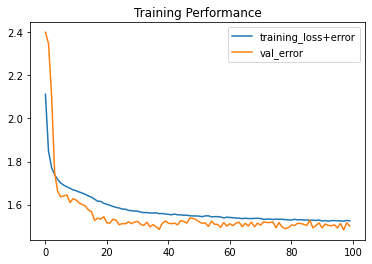

{'loss': [2.112592935562134, 1.8496276140213013, 1.7717373371124268, 1.7389142513275146, 1.7160841226577759, 1.699731707572937, 1.689780354499817, 1.6822022199630737, 1.6755211353302002, 1.668047547340393, 1.6639504432678223, 1.6583298444747925, 1.6531745195388794, 1.6471867561340332, 1.6399190425872803, 1.6344764232635498, 1.6246285438537598, 1.61545991897583, 1.6147319078445435, 1.6056246757507324, 1.601230502128601, 1.5965462923049927, 1.5909889936447144, 1.5869883298873901, 1.5838748216629028, 1.5787982940673828, 1.5785473585128784, 1.5729190111160278, 1.57142972946167, 1.5693254470825195, 1.5695054531097412, 1.5647737979888916, 1.562585711479187, 1.562949538230896, 1.5605264902114868, 1.5605751276016235, 1.5613869428634644, 1.5578075647354126, 1.5581974983215332, 1.5561410188674927, 1.5543559789657593, 1.5523157119750977, 1.5557267665863037, 1.5521286725997925, 1.552263855934143, 1.549904465675354, 1.550628900527954, 1.5478286743164062, 1.547006607055664, 1.546963095664978, 1.5461

In [ ]:
plt.figure()
plt.title("Training Performance")
plt.plot(history.epoch, history.history['loss'], label = 'training_loss+error')
plt.plot(history.epoch, history.history['val_loss'], label = 'val_error')
plt.legend()
plt.show()
print(history.history)
##plt.savefig('Loss_C.png')



> ### This is the third variation of Model 1. This first dense layer contains 128 filters, rather than 256 filters



In [ ]:
def CNN1_Model_Design_3(activation, in_shape, dr, classes):

  model = models.Sequential()
  model.add(Reshape([1] + in_shape, input_shape = in_shape))
  ##model.add(ZeroPadding2D((0, 2))) ## left_side is symmetric height pad, and right_side is symmetric width pad, so 2 on width
  model.add(Conv2D(256, (1, 3), activation = activation, padding = "same", name = "conv1", kernel_initializer = 'glorot_uniform'))
  # If you wanted to include batch normalisation

  model.add(Dropout(dr))
  #model.add(ZeroPadding2D((0, 2)))
  model.add(Conv2D(80, (2, 3), activation = activation, padding = "same", name = "conv2", kernel_initializer = 'glorot_uniform'))
  #If you wanted to include batch normalisation

  model.add(Dropout(dr))
  model.add(Flatten())
  model.add(Dense(128, activation = 'relu', kernel_initializer = 'he_normal', name = 'First_Dense_Layer'))
  model.add(Dropout(dr))
  model.add(Dense(len(classes), kernel_initializer = 'he_normal', name = 'Second_Dense_Layer'))
  model.add(Activation('softmax'))
  model.add(Reshape([len(classes)]))
  

  return model

In [ ]:
sig_model_3 = CNN1_Model_Design_3(activation = 'relu', in_shape = in_shp, dr = dr, classes = classes)
opt_2 = tf.keras.optimizers.Adam(learning_rate = 0.005)
sig_model_3.compile(loss = 'categorical_crossentropy', optimizer = opt_2, metrics = ['acc'])
sig_model_3.build()
sig_model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_6 (Reshape)         (None, 1, 2, 128)         0         
                                                                 
 conv1 (Conv2D)              (None, 1, 2, 256)         98560     
                                                                 
 dropout_9 (Dropout)         (None, 1, 2, 256)         0         
                                                                 
 conv2 (Conv2D)              (None, 1, 2, 80)          122960    
                                                                 
 dropout_10 (Dropout)        (None, 1, 2, 80)          0         
                                                                 
 flatten_3 (Flatten)         (None, 160)               0         
                                                                 
 First_Dense_Layer (Dense)   (None, 128)              

In [ ]:
filepath_6 = 'CNN1_3.h5'
sig_model_3.compile (loss = 'categorical_crossentropy', optimizer = opt_2, metrics = ['acc'])
history = sig_model_3.fit(X_train,
                        Y_train,
                        batch_size = batch_size,
                        epochs = epochs_val,
                        verbose = 2,
                        validation_data = (X_test, Y_test),
                        callbacks = [
                          keras.callbacks.ModelCheckpoint(filepath_6,
                                                          monitor = 'val_acc',
                                                          verbose = 0,
                                                          save_best_only = True,
                                                          mode = 'auto'),           
                        ])


Epoch 1/100
172/172 - 2s - loss: 2.0720 - acc: 0.2099 - val_loss: 1.8255 - val_acc: 0.2933 - 2s/epoch - 14ms/step
Epoch 2/100
172/172 - 1s - loss: 1.8264 - acc: 0.3045 - val_loss: 1.7107 - val_acc: 0.3366 - 906ms/epoch - 5ms/step
Epoch 3/100
172/172 - 1s - loss: 1.7432 - acc: 0.3353 - val_loss: 1.6670 - val_acc: 0.3548 - 906ms/epoch - 5ms/step
Epoch 4/100
172/172 - 1s - loss: 1.7021 - acc: 0.3491 - val_loss: 1.6339 - val_acc: 0.3794 - 888ms/epoch - 5ms/step
Epoch 5/100
172/172 - 1s - loss: 1.6808 - acc: 0.3564 - val_loss: 1.6140 - val_acc: 0.3801 - 888ms/epoch - 5ms/step
Epoch 6/100
172/172 - 1s - loss: 1.6681 - acc: 0.3604 - val_loss: 1.5971 - val_acc: 0.3786 - 857ms/epoch - 5ms/step
Epoch 7/100
172/172 - 1s - loss: 1.6570 - acc: 0.3653 - val_loss: 1.5990 - val_acc: 0.3889 - 887ms/epoch - 5ms/step
Epoch 8/100
172/172 - 1s - loss: 1.6469 - acc: 0.3684 - val_loss: 1.5920 - val_acc: 0.3873 - 856ms/epoch - 5ms/step
Epoch 9/100
172/172 - 1s - loss: 1.6396 - acc: 0.3711 - val_loss: 1.5840 -

In [ ]:
sig_model_3.load_weights(filepath_6)

score = sig_model_3.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print(score)

[1.4704622030258179, 0.44061362743377686]


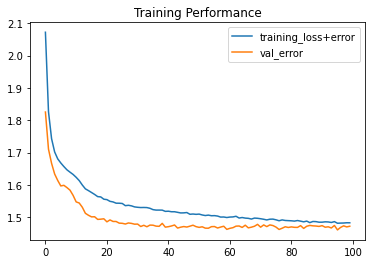

{'loss': [2.07200026512146, 1.826358437538147, 1.743221640586853, 1.7021379470825195, 1.680784821510315, 1.668054461479187, 1.657021164894104, 1.6468987464904785, 1.63960599899292, 1.6325970888137817, 1.6237260103225708, 1.613486886024475, 1.5998799800872803, 1.5880688428878784, 1.5826029777526855, 1.5767688751220703, 1.5708189010620117, 1.564095139503479, 1.5631065368652344, 1.5560743808746338, 1.5547860860824585, 1.5494829416275024, 1.5476495027542114, 1.5437606573104858, 1.5436686277389526, 1.542842984199524, 1.5361049175262451, 1.5372943878173828, 1.535499095916748, 1.5322872400283813, 1.5310697555541992, 1.530303955078125, 1.5305240154266357, 1.5302164554595947, 1.5279865264892578, 1.5238420963287354, 1.5224518775939941, 1.5224586725234985, 1.5223183631896973, 1.5184922218322754, 1.5189788341522217, 1.5173407793045044, 1.5173473358154297, 1.5154982805252075, 1.5136313438415527, 1.5138678550720215, 1.5148417949676514, 1.5095036029815674, 1.5102945566177368, 1.509293556213379, 1.510

In [ ]:
plt.figure()
plt.title("Training Performance")
plt.plot(history.epoch, history.history['loss'], label = 'training_loss+error')
plt.plot(history.epoch, history.history['val_loss'], label = 'val_error')
plt.legend()
plt.show()
print(history.history)
##plt.savefig('Loss_C.png')

#CNN Second Model

In [ ]:
def CNN2_Model_Build(activation, in_shape, dr, classes):
    model = models.Sequential()
    model.add(Reshape([1] + in_shape, input_shape = in_shape))
    model.add(Conv2D(256, (1, 2), padding = "same", input_shape = (1, 2, 128), activation = activation, kernel_initializer = 'glorot_uniform'))
    model.add(tf.keras.layers.SeparableConv2D(256, kernel_size = (1, 2), padding = "same", input_shape = (1, 2, 256), activation = None,
                                              depth_multiplier = 2, kernel_initializer = 'glorot_uniform'))
    
    # If you wanted to include batch normalisation

    model.add(Dropout(dr))
    model.add(Conv2D(256, (1, 2), padding = "same", input_shape = (1, 2, 128), activation = activation, kernel_initializer = 'glorot_uniform'))
    model.add(tf.keras.layers.SeparableConv2D(80, kernel_size = (1, 2), padding = "same", input_shape = (1, 2, 256), activation = None,
                                              depth_multiplier = 2, kernel_initializer = 'glorot_uniform'))
    
    # If you wanted to include batch normalisation
    
    model.add(Flatten())
    model.add(Dense(80, activation = activation, kernel_initializer = 'he_normal'))
    model.add(Dropout(dr))

    model.add(Dense(len(classes), activation = 'softmax'))
    model.add(Reshape([len(classes)]))

    return model


In [ ]:
sig_2_model = CNN2_Model_Build(activation = 'relu', in_shape = in_shp, dr = dr, classes = classes)
opt_2_1 = tf.keras.optimizers.Adam(learning_rate = 0.005)
sig_2_model.compile(loss = 'categorical_crossentropy', optimizer = opt_2_1, metrics = ['acc'])
sig_2_model.build()
sig_2_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_8 (Reshape)         (None, 1, 2, 128)         0         
                                                                 
 conv2d (Conv2D)             (None, 1, 2, 256)         65792     
                                                                 
 separable_conv2d (Separable  (None, 1, 2, 256)        132352    
 Conv2D)                                                         
                                                                 
 dropout_12 (Dropout)        (None, 1, 2, 256)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 1, 2, 256)         131328    
                                                                 
 separable_conv2d_1 (Separab  (None, 1, 2, 80)         42064     
 leConv2D)                                            

In [ ]:
filepath_3 = 'CNN2_1.h5'
##sig_2_model.compile (loss = 'categorical_crossentropy', optimizer = opt_2_1, metrics = ['acc'])
history = sig_2_model.fit(X_train,
                        Y_train,
                        batch_size = batch_size,
                        epochs = epochs_val,
                        verbose = 2,
                        validation_data = (X_test, Y_test),
                        callbacks = [
                          keras.callbacks.ModelCheckpoint(filepath_3,
                                                          monitor = 'val_acc',
                                                          verbose = 0,
                                                          save_best_only = True,
                                                          mode = 'auto'),           
                        ])


Epoch 1/100
172/172 - 4s - loss: 2.2263 - acc: 0.1559 - val_loss: 2.1090 - val_acc: 0.2050 - 4s/epoch - 23ms/step
Epoch 2/100
172/172 - 2s - loss: 1.9480 - acc: 0.2677 - val_loss: 1.7739 - val_acc: 0.3206 - 2s/epoch - 9ms/step
Epoch 3/100
172/172 - 2s - loss: 1.7281 - acc: 0.3376 - val_loss: 1.6367 - val_acc: 0.3643 - 2s/epoch - 9ms/step
Epoch 4/100
172/172 - 2s - loss: 1.6317 - acc: 0.3718 - val_loss: 1.5692 - val_acc: 0.3912 - 2s/epoch - 9ms/step
Epoch 5/100
172/172 - 2s - loss: 1.5522 - acc: 0.3951 - val_loss: 1.4987 - val_acc: 0.4090 - 2s/epoch - 9ms/step
Epoch 6/100
172/172 - 2s - loss: 1.5077 - acc: 0.4064 - val_loss: 1.4772 - val_acc: 0.4153 - 2s/epoch - 9ms/step
Epoch 7/100
172/172 - 2s - loss: 1.4813 - acc: 0.4170 - val_loss: 1.4483 - val_acc: 0.4295 - 2s/epoch - 9ms/step
Epoch 8/100
172/172 - 2s - loss: 1.4613 - acc: 0.4268 - val_loss: 1.4490 - val_acc: 0.4318 - 2s/epoch - 9ms/step
Epoch 9/100
172/172 - 2s - loss: 1.4479 - acc: 0.4308 - val_loss: 1.4333 - val_acc: 0.4393 - 2s

In [ ]:
sig_2_model.load_weights(filepath_3)

score = sig_2_model.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print(score)

[1.4821761846542358, 0.46409091353416443]


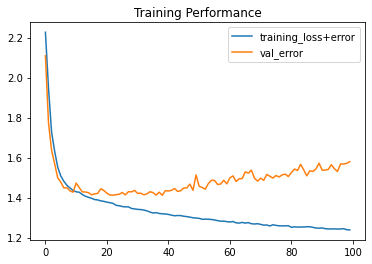

{'loss': [2.226349353790283, 1.9479650259017944, 1.72813880443573, 1.6316885948181152, 1.5521622896194458, 1.5076688528060913, 1.481290340423584, 1.4612737894058228, 1.4479182958602905, 1.4351216554641724, 1.4288822412490845, 1.4266546964645386, 1.4152112007141113, 1.406633973121643, 1.4015203714370728, 1.3964142799377441, 1.39029061794281, 1.3881934881210327, 1.3834772109985352, 1.3812025785446167, 1.3769872188568115, 1.3743518590927124, 1.370921015739441, 1.361191749572754, 1.3592555522918701, 1.3551768064498901, 1.3535068035125732, 1.3536709547042847, 1.3456608057022095, 1.3432655334472656, 1.3410701751708984, 1.3400987386703491, 1.3376504182815552, 1.333803415298462, 1.3276069164276123, 1.3228532075881958, 1.3247528076171875, 1.320555567741394, 1.3190008401870728, 1.3181809186935425, 1.3157474994659424, 1.3121813535690308, 1.3090808391571045, 1.310402750968933, 1.3098907470703125, 1.3067433834075928, 1.3048323392868042, 1.3022687435150146, 1.2990108728408813, 1.2977720499038696, 1.

In [ ]:
plt.figure()
plt.title("Training Performance")
plt.plot(history.epoch, history.history['loss'], label = 'training_loss+error')
plt.plot(history.epoch, history.history['val_loss'], label = 'val_error')
plt.legend()
plt.show()
print(history.history)
##plt.savefig('Loss_C.png')



> ### This is a variation of Model 2, contains batch_normalization



In [ ]:
def CNN2_Model_Build_2(batch_normalization, activation, in_shape, dr, classes):
    model = models.Sequential()
    model.add(Reshape([1] + in_shape, input_shape = in_shape))
    model.add(Conv2D(256, (1, 2), padding = "same", input_shape = (1, 2, 128), activation = activation, kernel_initializer = 'glorot_uniform'))
    model.add(tf.keras.layers.SeparableConv2D(256, kernel_size = (1, 2), padding = "same", input_shape = (1, 2, 256), activation = None,
                                              depth_multiplier = 2, kernel_initializer = 'glorot_uniform'))
    
    # If you wanted to include batch normalisation
    if(batch_normalization):
        model.add(tf.keras.layers.BatchNormalization())

    model.add(Dropout(dr))
    model.add(Conv2D(256, (1, 2), padding = "same", input_shape = (1, 2, 128), activation = activation, kernel_initializer = 'glorot_uniform'))
    model.add(tf.keras.layers.SeparableConv2D(80, kernel_size = (1, 2), padding = "same", input_shape = (1, 2, 256), activation = None,
                                              depth_multiplier = 2, kernel_initializer = 'glorot_uniform'))
    
    # If you wanted to include batch normalisation
    if(batch_normalization):
        model.add(tf.keras.layers.BatchNormalization())
    
    model.add(Flatten())
    model.add(Dense(80, activation = activation, kernel_initializer = 'he_normal'))
    model.add(Dropout(dr))

    model.add(Dense(len(classes), activation = 'softmax'))
    model.add(Reshape([len(classes)]))

    return model

In [ ]:
sig_2_model_2 = CNN2_Model_Build_2(batch_normalization = True, activation = 'relu', in_shape = in_shp, dr = dr, classes = classes)
opt_2_1 = tf.keras.optimizers.Adam(learning_rate = 0.005)
sig_2_model_2.compile(loss = 'categorical_crossentropy', optimizer = opt_2_1, metrics = ['acc'])
sig_2_model_2.build()
sig_2_model_2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_10 (Reshape)        (None, 1, 2, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 2, 256)         65792     
                                                                 
 separable_conv2d_2 (Separab  (None, 1, 2, 256)        132352    
 leConv2D)                                                       
                                                                 
 batch_normalization_2 (Batc  (None, 1, 2, 256)        1024      
 hNormalization)                                                 
                                                                 
 dropout_14 (Dropout)        (None, 1, 2, 256)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 1, 2, 256)        

In [ ]:
filepath_4 = 'CNN2_2.h5'
##sig_2_model.compile (loss = 'categorical_crossentropy', optimizer = opt_2_1, metrics = ['acc'])
history = sig_2_model_2.fit(X_train,
                        Y_train,
                        batch_size = batch_size,
                        epochs = epochs_val,
                        verbose = 2,
                        validation_data = (X_test, Y_test),
                        callbacks = [
                          keras.callbacks.ModelCheckpoint(filepath_4,
                                                          monitor = 'val_acc',
                                                          verbose = 0,
                                                          save_best_only = True,
                                                          mode = 'auto'),           
                        ])

Epoch 1/100
172/172 - 3s - loss: 1.8355 - acc: 0.3028 - val_loss: 2.4191 - val_acc: 0.0964 - 3s/epoch - 16ms/step
Epoch 2/100
172/172 - 2s - loss: 1.6215 - acc: 0.3773 - val_loss: 2.3217 - val_acc: 0.1445 - 2s/epoch - 9ms/step
Epoch 3/100
172/172 - 2s - loss: 1.5788 - acc: 0.3895 - val_loss: 2.0996 - val_acc: 0.2103 - 2s/epoch - 9ms/step
Epoch 4/100
172/172 - 2s - loss: 1.5309 - acc: 0.4057 - val_loss: 1.9643 - val_acc: 0.3014 - 2s/epoch - 9ms/step
Epoch 5/100
172/172 - 2s - loss: 1.4843 - acc: 0.4200 - val_loss: 1.6177 - val_acc: 0.3829 - 2s/epoch - 9ms/step
Epoch 6/100
172/172 - 2s - loss: 1.4631 - acc: 0.4263 - val_loss: 1.6557 - val_acc: 0.3845 - 2s/epoch - 9ms/step
Epoch 7/100
172/172 - 2s - loss: 1.4481 - acc: 0.4315 - val_loss: 1.4467 - val_acc: 0.4196 - 2s/epoch - 10ms/step
Epoch 8/100
172/172 - 2s - loss: 1.4385 - acc: 0.4357 - val_loss: 1.4567 - val_acc: 0.4292 - 2s/epoch - 10ms/step
Epoch 9/100
172/172 - 2s - loss: 1.4282 - acc: 0.4386 - val_loss: 1.4481 - val_acc: 0.4345 - 

In [ ]:
sig_2_model_2.load_weights(filepath_4)

score = sig_2_model_2.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print(score)

[1.4728665351867676, 0.47863635420799255]


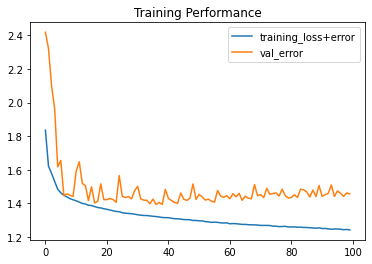

{'loss': [1.835513710975647, 1.6214663982391357, 1.5788142681121826, 1.5308973789215088, 1.484257459640503, 1.463096261024475, 1.4481102228164673, 1.4384856224060059, 1.4281522035598755, 1.4215142726898193, 1.415612816810608, 1.407734990119934, 1.3997961282730103, 1.3963483572006226, 1.3888602256774902, 1.3871173858642578, 1.3812174797058105, 1.3754619359970093, 1.373040795326233, 1.3680824041366577, 1.3647361993789673, 1.3605984449386597, 1.3560431003570557, 1.3518437147140503, 1.3504626750946045, 1.3445086479187012, 1.3416582345962524, 1.340193748474121, 1.3381606340408325, 1.3358925580978394, 1.3322813510894775, 1.3299226760864258, 1.3279508352279663, 1.3275517225265503, 1.3255431652069092, 1.3231592178344727, 1.3217201232910156, 1.3191874027252197, 1.3160722255706787, 1.3149347305297852, 1.3149734735488892, 1.3115448951721191, 1.3088475465774536, 1.3081450462341309, 1.3064541816711426, 1.3037053346633911, 1.303357720375061, 1.3027175664901733, 1.298221230506897, 1.2982492446899414,

In [ ]:
plt.figure()
plt.title("Training Performance")
plt.plot(history.epoch, history.history['loss'], label = 'training_loss+error')
plt.plot(history.epoch, history.history['val_loss'], label = 'val_error')
plt.legend()
plt.show()
print(history.history)
##plt.savefig('Loss_C.png')

#CNN Third Model



> Third CNN model, 4 layers deep



In [ ]:
def CNN3_Model_Design_1(activation, in_shape, dr, classes):

  model = models.Sequential()
  model.add(Reshape([1] + in_shape, input_shape = in_shape))
  model.add(ZeroPadding2D((0, 2))) ## left_side is symmetric height pad, and right_side is symmetric width pad, so 2 on width
  model.add(Conv2D(256, (1, 3), activation = activation, padding = "same", name = "conv1", kernel_initializer = 'glorot_uniform'))
  # If you wanted to include batch normalisation

  model.add(Dropout(dr))
  model.add(ZeroPadding2D((0, 2)))

  model.add(Conv2D(256, (2, 3), activation = activation, padding = "same", name = "conv2", kernel_initializer = 'glorot_uniform'))
  model.add(Dropout(dr))
  model.add(ZeroPadding2D((0, 2)))

  model.add(Conv2D(80, (1, 3), activation = activation, padding = "same", name = "conv3", kernel_initializer = 'glorot_uniform'))
  model.add(Dropout(dr))
  model.add(ZeroPadding2D((0, 2)))

  model.add(Conv2D(80, (1, 3), activation = activation, padding = "same", name = "conv4", kernel_initializer = 'glorot_uniform'))

  #If you wanted to include batch normalisation

  model.add(Dropout(dr))
  model.add(Flatten())
  model.add(Dense(128, activation = 'relu', kernel_initializer = 'he_normal', name = 'First_Dense_Layer'))
  model.add(Dropout(dr))
  model.add(Dense(len(classes), kernel_initializer = 'he_normal', name = 'Second_Dense_Layer'))
  model.add(Activation('softmax'))
  model.add(Reshape([len(classes)]))
  

  return model

In [ ]:
sig_3_model_1 = CNN3_Model_Design_1(activation = 'relu', in_shape = in_shp, dr = dr, classes = classes)
opt_2_1 = tf.keras.optimizers.Adam(learning_rate = 0.005)
sig_3_model_1.compile(loss = 'categorical_crossentropy', optimizer = opt_2_1, metrics = ['acc'])
sig_3_model_1.build()
sig_3_model_1.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_13 (Reshape)        (None, 1, 2, 128)         0         
                                                                 
 zero_padding2d_9 (ZeroPaddi  (None, 1, 6, 128)        0         
 ng2D)                                                           
                                                                 
 conv1 (Conv2D)              (None, 1, 6, 256)         98560     
                                                                 
 dropout_18 (Dropout)        (None, 1, 6, 256)         0         
                                                                 
 zero_padding2d_10 (ZeroPadd  (None, 1, 10, 256)       0         
 ing2D)                                                          
                                                                 
 conv2 (Conv2D)              (None, 1, 10, 256)       

In [ ]:
filepath_8 = 'CNN3_1.h5'
##sig_2_model.compile (loss = 'categorical_crossentropy', optimizer = opt_2_1, metrics = ['acc'])
history = sig_3_model_1.fit(X_train,
                        Y_train,
                        batch_size = batch_size,
                        epochs = epochs_val,
                        verbose = 2,
                        validation_data = (X_test, Y_test),
                        callbacks = [
                          keras.callbacks.ModelCheckpoint(filepath_8,
                                                          monitor = 'val_acc',
                                                          verbose = 0,
                                                          save_best_only = True,
                                                          mode = 'auto'),           
                        ])

Epoch 1/100
172/172 - 6s - loss: 2.1841 - acc: 0.1758 - val_loss: 1.9647 - val_acc: 0.2667 - 6s/epoch - 37ms/step
Epoch 2/100
172/172 - 3s - loss: 1.9214 - acc: 0.2804 - val_loss: 1.7804 - val_acc: 0.3109 - 3s/epoch - 20ms/step
Epoch 3/100
172/172 - 3s - loss: 1.8125 - acc: 0.3112 - val_loss: 1.7375 - val_acc: 0.3240 - 3s/epoch - 20ms/step
Epoch 4/100
172/172 - 4s - loss: 1.7603 - acc: 0.3273 - val_loss: 1.6827 - val_acc: 0.3552 - 4s/epoch - 20ms/step
Epoch 5/100
172/172 - 3s - loss: 1.7321 - acc: 0.3344 - val_loss: 1.6840 - val_acc: 0.3433 - 3s/epoch - 20ms/step
Epoch 6/100
172/172 - 4s - loss: 1.7147 - acc: 0.3408 - val_loss: 1.6550 - val_acc: 0.3699 - 4s/epoch - 20ms/step
Epoch 7/100
172/172 - 3s - loss: 1.6998 - acc: 0.3475 - val_loss: 1.6553 - val_acc: 0.3622 - 3s/epoch - 20ms/step
Epoch 8/100
172/172 - 3s - loss: 1.6933 - acc: 0.3491 - val_loss: 1.6526 - val_acc: 0.3568 - 3s/epoch - 20ms/step
Epoch 9/100
172/172 - 3s - loss: 1.6835 - acc: 0.3539 - val_loss: 1.6502 - val_acc: 0.34

In [ ]:
sig_3_model_1.load_weights(filepath_8)

score = sig_3_model_1.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print(score)

[1.5029956102371216, 0.4135454595088959]


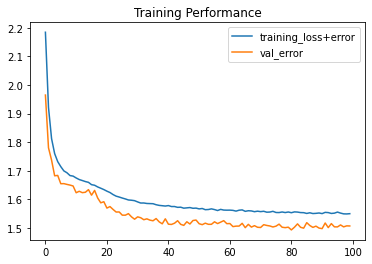

{'loss': [2.184091091156006, 1.9213820695877075, 1.8125461339950562, 1.760262131690979, 1.7321385145187378, 1.7146739959716797, 1.6997990608215332, 1.6933125257492065, 1.6834746599197388, 1.681588053703308, 1.6751383543014526, 1.6695812940597534, 1.66612708568573, 1.6625083684921265, 1.659844994544983, 1.6516859531402588, 1.6496541500091553, 1.6437517404556274, 1.6392765045166016, 1.6345560550689697, 1.62900710105896, 1.6242088079452515, 1.617125391960144, 1.6115736961364746, 1.6084824800491333, 1.6049790382385254, 1.6018602848052979, 1.5982341766357422, 1.5973385572433472, 1.595799207687378, 1.591444969177246, 1.5875344276428223, 1.5877127647399902, 1.5860267877578735, 1.5856045484542847, 1.5851999521255493, 1.5816717147827148, 1.5793229341506958, 1.5782090425491333, 1.5769953727722168, 1.57868230342865, 1.575274109840393, 1.5753711462020874, 1.572482943534851, 1.5730431079864502, 1.5696076154708862, 1.5706475973129272, 1.5717490911483765, 1.5692278146743774, 1.5698071718215942, 1.567

In [ ]:
plt.figure()
plt.title("Training Performance")
plt.plot(history.epoch, history.history['loss'], label = 'training_loss+error')
plt.plot(history.epoch, history.history['val_loss'], label = 'val_error')
plt.legend()
plt.show()
print(history.history)
##plt.savefig('Loss_C.png')

> ## CNN Model 4



In [ ]:
def CNN3_Model_Design_2(batch_normalization, activation, in_shape, dr, classes):

  model = models.Sequential()
  model.add(Reshape([1] + in_shape, input_shape = in_shape))
  model.add(ZeroPadding2D((0, 2))) ## left_side is symmetric height pad, and right_side is symmetric width pad, so 2 on width
  model.add(Conv2D(256, (1, 3), activation = activation, padding = "same", name = "conv1", kernel_initializer = 'glorot_uniform'))
  # If you wanted to include batch normalisation
  if(batch_normalization):
      model.add(tf.keras.layers.BatchNormalization())

  model.add(Conv2D(256, (2, 3), activation = activation, padding = "same", name = "conv2", kernel_initializer = 'glorot_uniform'))

  if(batch_normalization):
      model.add(tf.keras.layers.BatchNormalization())

  model.add(Conv2D(80, (1, 3), activation = activation, padding = "same", name = "conv3", kernel_initializer = 'glorot_uniform'))

  if(batch_normalization):
      model.add(tf.keras.layers.BatchNormalization())

  model.add(Conv2D(80, (1, 3), activation = activation, padding = "same", name = "conv4", kernel_initializer = 'glorot_uniform'))

  if(batch_normalization):
      model.add(tf.keras.layers.BatchNormalization())

  #If you wanted to include batch normalisation

  ##model.add(Dropout(dr))
  model.add(Flatten())
  model.add(Dense(128, activation = 'relu', kernel_initializer = 'he_normal', name = 'First_Dense_Layer'))
  model.add(Dropout(dr))
  model.add(Dense(len(classes), kernel_initializer = 'he_normal', name = 'Second_Dense_Layer'))
  model.add(Activation('softmax'))
  model.add(Reshape([len(classes)]))
  

  return model

In [ ]:
sig_3_model_2 = CNN3_Model_Design_2(batch_normalization = True, activation = 'relu', in_shape = in_shp, dr = dr, classes = classes)
opt_2_1 = tf.keras.optimizers.Adam(learning_rate = 0.005)
sig_3_model_2.compile(loss = 'categorical_crossentropy', optimizer = opt_2_1, metrics = ['acc'])
sig_3_model_2.build()
sig_3_model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_15 (Reshape)        (None, 1, 2, 128)         0         
                                                                 
 zero_padding2d_13 (ZeroPadd  (None, 1, 6, 128)        0         
 ing2D)                                                          
                                                                 
 conv1 (Conv2D)              (None, 1, 6, 256)         98560     
                                                                 
 batch_normalization_4 (Batc  (None, 1, 6, 256)        1024      
 hNormalization)                                                 
                                                                 
 conv2 (Conv2D)              (None, 1, 6, 256)         393472    
                                                                 
 batch_normalization_5 (Batc  (None, 1, 6, 256)       

In [ ]:
filepath_9 = 'CNN4_2.h5'
##sig_2_model.compile (loss = 'categorical_crossentropy', optimizer = opt_2_1, metrics = ['acc'])
history = sig_3_model_2.fit(X_train,
                        Y_train,
                        batch_size = batch_size,
                        epochs = epochs_val,
                        verbose = 2,
                        validation_data = (X_test, Y_test),
                        callbacks = [
                          keras.callbacks.ModelCheckpoint(filepath_9,
                                                          monitor = 'val_acc',
                                                          verbose = 0,
                                                          save_best_only = True,
                                                          mode = 'auto'),           
                        ])

Epoch 1/100
172/172 - 6s - loss: 1.8474 - acc: 0.3045 - val_loss: 2.5626 - val_acc: 0.0898 - 6s/epoch - 34ms/step
Epoch 2/100
172/172 - 3s - loss: 1.6114 - acc: 0.3769 - val_loss: 2.4869 - val_acc: 0.1233 - 3s/epoch - 15ms/step
Epoch 3/100
172/172 - 3s - loss: 1.5042 - acc: 0.4070 - val_loss: 1.9711 - val_acc: 0.2366 - 3s/epoch - 15ms/step
Epoch 4/100
172/172 - 3s - loss: 1.4596 - acc: 0.4224 - val_loss: 1.5742 - val_acc: 0.3726 - 3s/epoch - 15ms/step
Epoch 5/100
172/172 - 3s - loss: 1.4341 - acc: 0.4338 - val_loss: 1.8976 - val_acc: 0.3726 - 3s/epoch - 15ms/step
Epoch 6/100
172/172 - 3s - loss: 1.4120 - acc: 0.4449 - val_loss: 2.0918 - val_acc: 0.3667 - 3s/epoch - 15ms/step
Epoch 7/100
172/172 - 3s - loss: 1.3925 - acc: 0.4525 - val_loss: 2.2409 - val_acc: 0.3646 - 3s/epoch - 15ms/step
Epoch 8/100
172/172 - 3s - loss: 1.3773 - acc: 0.4597 - val_loss: 2.4454 - val_acc: 0.3535 - 3s/epoch - 15ms/step
Epoch 9/100
172/172 - 3s - loss: 1.3650 - acc: 0.4651 - val_loss: 2.0183 - val_acc: 0.37

In [ ]:
sig_3_model_2.load_weights(filepath_9)

score = sig_3_model_2.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print(score)

[1.4316855669021606, 0.4625454545021057]


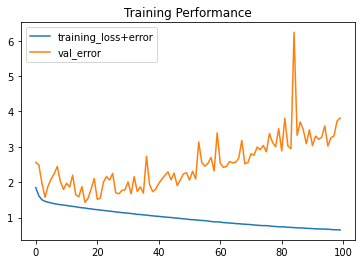

{'loss': [1.8474483489990234, 1.6113560199737549, 1.5041606426239014, 1.4595636129379272, 1.434128999710083, 1.412009835243225, 1.3924778699874878, 1.3773257732391357, 1.3649961948394775, 1.3529248237609863, 1.34157133102417, 1.3269286155700684, 1.3161869049072266, 1.3056979179382324, 1.2886992692947388, 1.2770860195159912, 1.269007682800293, 1.2538766860961914, 1.2446855306625366, 1.2310950756072998, 1.2217843532562256, 1.2134348154067993, 1.2018321752548218, 1.1911108493804932, 1.1809502840042114, 1.1712075471878052, 1.1588592529296875, 1.1510391235351562, 1.1394906044006348, 1.1321226358413696, 1.1245697736740112, 1.1140426397323608, 1.103743553161621, 1.0894283056259155, 1.0871458053588867, 1.0751789808273315, 1.069737434387207, 1.056929111480713, 1.0491317510604858, 1.0393532514572144, 1.0335367918014526, 1.0234907865524292, 1.0145364999771118, 1.0072216987609863, 1.0017945766448975, 0.9896321296691895, 0.9836546778678894, 0.97514408826828, 0.9656730890274048, 0.9578456282615662, 

In [ ]:
plt.figure()
plt.title("Training Performance")
plt.plot(history.epoch, history.history['loss'], label = 'training_loss+error')
plt.plot(history.epoch, history.history['val_loss'], label = 'val_error')
plt.legend()
plt.show()
print(history.history)
##plt.savefig('Loss_C.png')

# CNN Model 5

In [ ]:
def CNN5_Model_Design_1(activation, in_shape, dr, classes):

  model = models.Sequential()
  model.add(Reshape([1] + in_shape, input_shape = in_shape))
  model.add(ZeroPadding2D((0, 2))) ## left_side is symmetric height pad, and right_side is symmetric width pad, so 2 on width
  model.add(Conv2D(384, (1, 3), activation = activation, padding = "same", name = "conv1", kernel_initializer = 'glorot_uniform'))
  # If you wanted to include batch normalisation

  model.add(Dropout(dr))
  model.add(ZeroPadding2D((0, 2)))

  model.add(Conv2D(256, (2, 3), activation = activation, padding = "same", name = "conv2", kernel_initializer = 'glorot_uniform'))
  model.add(Dropout(dr))
  model.add(ZeroPadding2D((0, 2)))

  model.add(Conv2D(80, (1, 3), activation = activation, padding = "same", name = "conv3", kernel_initializer = 'glorot_uniform'))
  model.add(Dropout(dr))
  model.add(ZeroPadding2D((0, 2)))

  model.add(Conv2D(256, (1, 3), activation = activation, padding = "same", name = "conv4", kernel_initializer = 'glorot_uniform'))
  model.add(Dropout(dr))
  model.add(ZeroPadding2D((0, 2)))

  model.add(Conv2D(80, (1, 3), activation = activation, padding = "same", name = "conv5", kernel_initializer = 'glorot_uniform'))
  ##model.add(Dropout(dr))
  ##model.add(ZeroPadding2D((0, 2)))

  #If you wanted to include batch normalisation

  model.add(Dropout(dr))
  model.add(Flatten())
  model.add(Dense(128, activation = 'relu', kernel_initializer = 'he_normal', name = 'First_Dense_Layer'))
  model.add(Dropout(dr))
  model.add(Dense(len(classes), kernel_initializer = 'he_normal', name = 'Second_Dense_Layer'))
  model.add(Activation('softmax'))
  model.add(Reshape([len(classes)]))
  

  return model

In [ ]:
sig_5_model_1 = CNN5_Model_Design_1(activation = 'relu', in_shape = in_shp, dr = dr, classes = classes)
opt_2_1 = tf.keras.optimizers.Adam(learning_rate = 0.005)
sig_5_model_1.compile(loss = 'categorical_crossentropy', optimizer = opt_2_1, metrics = ['acc'])
sig_5_model_1.build()
sig_5_model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_18 (Reshape)        (None, 1, 2, 128)         0         
                                                                 
 zero_padding2d_19 (ZeroPadd  (None, 1, 6, 128)        0         
 ing2D)                                                          
                                                                 
 conv1 (Conv2D)              (None, 1, 6, 384)         147840    
                                                                 
 dropout_28 (Dropout)        (None, 1, 6, 384)         0         
                                                                 
 zero_padding2d_20 (ZeroPadd  (None, 1, 10, 384)       0         
 ing2D)                                                          
                                                                 
 conv2 (Conv2D)              (None, 1, 10, 256)      

In [ ]:
filepath_10 = 'CNN5_1.h5'
##sig_2_model.compile (loss = 'categorical_crossentropy', optimizer = opt_2_1, metrics = ['acc'])
history = sig_5_model_1.fit(X_train,
                        Y_train,
                        batch_size = batch_size,
                        epochs = epochs_val,
                        verbose = 2,
                        validation_data = (X_test, Y_test),
                        callbacks = [
                          keras.callbacks.ModelCheckpoint(filepath_10,
                                                          monitor = 'val_acc',
                                                          verbose = 0,
                                                          save_best_only = True,
                                                          mode = 'auto'),           
                        ])

Epoch 1/100
172/172 - 10s - loss: 2.1953 - acc: 0.1740 - val_loss: 2.0208 - val_acc: 0.2411 - 10s/epoch - 61ms/step
Epoch 2/100
172/172 - 6s - loss: 1.9516 - acc: 0.2674 - val_loss: 1.8573 - val_acc: 0.2980 - 6s/epoch - 33ms/step
Epoch 3/100
172/172 - 6s - loss: 1.8564 - acc: 0.2969 - val_loss: 1.7886 - val_acc: 0.3125 - 6s/epoch - 34ms/step
Epoch 4/100
172/172 - 6s - loss: 1.7926 - acc: 0.3155 - val_loss: 1.7502 - val_acc: 0.3185 - 6s/epoch - 33ms/step
Epoch 5/100
172/172 - 6s - loss: 1.7546 - acc: 0.3268 - val_loss: 1.7330 - val_acc: 0.3491 - 6s/epoch - 33ms/step
Epoch 6/100
172/172 - 6s - loss: 1.7348 - acc: 0.3322 - val_loss: 1.7107 - val_acc: 0.3359 - 6s/epoch - 32ms/step
Epoch 7/100
172/172 - 6s - loss: 1.7248 - acc: 0.3354 - val_loss: 1.7240 - val_acc: 0.3231 - 6s/epoch - 32ms/step
Epoch 8/100
172/172 - 6s - loss: 1.7132 - acc: 0.3415 - val_loss: 1.6792 - val_acc: 0.3538 - 6s/epoch - 36ms/step
Epoch 9/100
172/172 - 5s - loss: 1.7070 - acc: 0.3444 - val_loss: 1.6968 - val_acc: 0.

In [ ]:
sig_5_model_1.load_weights(filepath_10)

score = sig_5_model_1.evaluate(X_test, Y_test, verbose = 0, batch_size = batch_size)
print(score)

[1.5587986707687378, 0.39620453119277954]


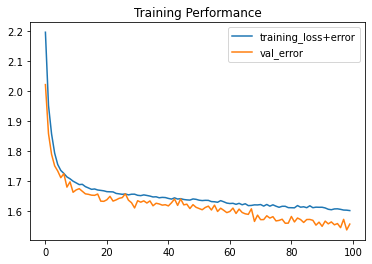

{'loss': [2.195319414138794, 1.9516173601150513, 1.8564398288726807, 1.7926316261291504, 1.7546367645263672, 1.7348103523254395, 1.7248334884643555, 1.7131702899932861, 1.7070046663284302, 1.698960542678833, 1.6933854818344116, 1.6876113414764404, 1.6885367631912231, 1.68086838722229, 1.6764036417007446, 1.6718404293060303, 1.6730409860610962, 1.6696876287460327, 1.6682956218719482, 1.666853666305542, 1.664056658744812, 1.6636457443237305, 1.6632509231567383, 1.6582307815551758, 1.6567723751068115, 1.6552457809448242, 1.6564955711364746, 1.6533631086349487, 1.6555708646774292, 1.6556739807128906, 1.651944637298584, 1.6508426666259766, 1.653322458267212, 1.651450276374817, 1.6493704319000244, 1.6464053392410278, 1.6470191478729248, 1.6437047719955444, 1.6450343132019043, 1.6444282531738281, 1.6415859460830688, 1.6393368244171143, 1.6434900760650635, 1.6394702196121216, 1.6408073902130127, 1.6380127668380737, 1.6366784572601318, 1.6360044479370117, 1.6398043632507324, 1.638514518737793, 

In [ ]:
plt.figure()
plt.title("Training Performance")
plt.plot(history.epoch, history.history['loss'], label = 'training_loss+error')
plt.plot(history.epoch, history.history['val_loss'], label = 'val_error')
plt.legend()
plt.show()
print(history.history)
##plt.savefig('Loss_C.png')